# Chess Piece Classification with CNN

## Preparing the data

In [1]:
import json
import numpy as np
from typing import List

from tensorflow.keras.preprocessing.image import load_img, img_to_array

N_SQUARES = 8  # Chessboard is 8x8 squares

def load_square_images(board_image_file: str) -> List[np.ndarray]:

    board_image = img_to_array(load_img(board_image_file, color_mode='grayscale'))
    assert board_image.shape[0] == board_image.shape[1]  # Square image

    sq_size = int(board_image.shape[0] / N_SQUARES) # pixel size
    
    # obtain individual images of all sqaures on a chess board
    images = []
    for row in range(N_SQUARES):
        for col in range(N_SQUARES):
            images.append(
                board_image[
                    row*sq_size : (row+1)*sq_size, 
                    col*sq_size : (col+1)*sq_size
                ]
            )
    
    return images # of shape (64, 50, 50, 1) (NUM_SQUARES_ON_CHESSBOARD, HEIGHT, WIDTH, DEPTH)

def load_board_images(image_dir: str, board_data: list) -> np.ndarray:

    # load squares for each board
    images = []
    for board_dict in board_data:
        board_image_file = f'./data/{image_dir}/{board_dict["image"]}'
        images.append(load_square_images(board_image_file))
        
    return np.array(images)

def load_board_labels(board_data: list) -> np.ndarray:
    
    labels = []
    for board in board_data:
        for s in board["board"]:
            labels += list(s)

    return np.array(labels)

## Loading and preprocessing the data

In [2]:
def load_data():
    
    # training data
    with open('./data/boards.train.json') as training_file:
        data = json.load(training_file)

    train_data = load_board_images('clean', data)
    train_labels = load_board_labels(data)
    
    # test data
    with open('./data/boards.dev.json') as test_file:
        data = json.load(test_file)

    test_data = load_board_images('clean', data)
    test_labels = load_board_labels(data)
    
    train_data = train_data.reshape(100*64, 50, 50, 1) # 100 boards, 6400 squares
    test_data = test_data.reshape(25*64, 50, 50, 1) # 25 boards, 1600 squares
    
    return (train_data, train_labels), (test_data, test_labels)

In [3]:
(train_data, train_labels), (test_data, test_labels) = load_data()

validation_data = train_data[4800:]
validation_labels = train_labels[4800:]
train_data = train_data[:4800]
train_labels = train_labels[:4800]

# normalise data
# scale pixels values in range [0,1]
# makes learning process easier for neural networks
train_data = train_data.astype('float32') / 255
test_data = test_data.astype('float32') / 255

In [4]:
PIECES = ['.', 'K', 'Q', 'B', 'N', 'R', 'P', 'k', 'q', 'b', 'n', 'r', 'p']

for p in PIECES:
    print(f"{p} {train_labels.tolist().count(p)}")

. 3659
K 74
Q 37
B 49
N 51
R 71
P 294
k 74
q 34
b 51
n 39
r 70
p 297


In [5]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

one_hot_train_labels = encoder.fit_transform(train_labels)
one_hot_validation_labels = encoder.fit_transform(validation_labels)
one_hot_test_labels = encoder.fit_transform(test_labels)

## Developing and training model

In [6]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# softmax typically used for output layer for single-label multi-class classification problems
model.add(layers.Dense(13, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, one_hot_train_labels, epochs=20, batch_size=48,
                    validation_data=(validation_data, one_hot_validation_labels)
)

test_loss, test_acc = model.evaluate(test_data, one_hot_test_labels)
test_acc

Epoch 1/20
100/100 [==============================] - 10s 95ms/step - loss: 0.7237 - accuracy: 0.8388 - val_loss: 137.6523 - val_accuracy: 0.8050
Epoch 2/20
100/100 [==============================] - 9s 94ms/step - loss: 0.1256 - accuracy: 0.9646 - val_loss: 28.3410 - val_accuracy: 0.9419
Epoch 3/20
100/100 [==============================] - 10s 97ms/step - loss: 0.0422 - accuracy: 0.9867 - val_loss: 139.7565 - val_accuracy: 0.8550
Epoch 4/20
100/100 [==============================] - 10s 102ms/step - loss: 0.0507 - accuracy: 0.9873 - val_loss: 89.4626 - val_accuracy: 0.8931
Epoch 5/20
100/100 [==============================] - 10s 102ms/step - loss: 0.0148 - accuracy: 0.9960 - val_loss: 6.5770 - val_accuracy: 0.9894
Epoch 6/20
100/100 [==============================] - 10s 105ms/step - loss: 0.0098 - accuracy: 0.9967 - val_loss: 450.6511 - val_accuracy: 0.8019
Epoch 7/20
100/100 [==============================] - 11s 107ms/step - loss: 0.0110 - accuracy: 0.9977 - val_loss: 18.8489 - v

0.9962499737739563

## Evaluating model and tuning hyperparameters

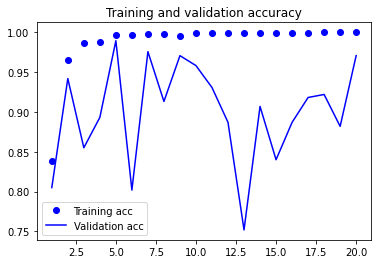

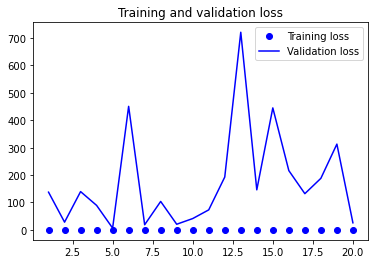

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))

model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history = model.fit(train_data, one_hot_train_labels, epochs=5, batch_size=48,
                    validation_data=(validation_data, one_hot_validation_labels)
)

test_loss, test_acc = model.evaluate(test_data, one_hot_test_labels)
test_acc

Epoch 1/5
100/100 [==============================] - 13s 126ms/step - loss: 0.7574 - accuracy: 0.8240 - val_loss: 42.0924 - val_accuracy: 0.8806
Epoch 2/5
100/100 [==============================] - 13s 134ms/step - loss: 0.1246 - accuracy: 0.9663 - val_loss: 18.8519 - val_accuracy: 0.9444
Epoch 3/5
100/100 [==============================] - 13s 135ms/step - loss: 0.0391 - accuracy: 0.9908 - val_loss: 90.0314 - val_accuracy: 0.8938
Epoch 4/5
100/100 [==============================] - 13s 132ms/step - loss: 0.0288 - accuracy: 0.9906 - val_loss: 23.2716 - val_accuracy: 0.9556
Epoch 5/5
50/50 [==============================] - 1s 28ms/step - loss: 0.0109 - accuracy: 0.9969


0.996874988079071